<a id="Introduction"></a>

<img src="https://valuegold.com/wp-content/uploads/2023/09/10.-Pros-and-Cons-of-Early-2.jpg"> <center><h1>💵 Loan Payback Prediction 💵</h1></center>
Introduction

How likely is a borrower to repay a loan on time? 🤔

Understanding loan repayment behavior is crucial for banks, microfinance institutions, and fintech companies. Predicting whether a borrower will default or pay back their loan on time helps in risk management, interest rate optimization, and decision-making for loan approvals.

🟢 Goal: This notebook aims to analyze historical loan data, understand the factors affecting loan repayment, and build a predictive model that estimates the likelihood of payback.

We will explore features such as:

Borrower demographics (annual income, employment status, education level, marital status)

Loan characteristics (amount, interest rate)

Payment history (previous defaults, repayment patterns)

External factors (economic indicators, seasonality if applicable)

By the end, we aim to predict which loans are at risk of default, helping institutions make informed lending decisions and reduce financial losses.

In [2]:
# To avoid non crutial warnings, like versions.
import warnings
warnings.simplefilter("ignore")

In [98]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,accuracy_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

scaler = StandardScaler()
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool


# optimization & explainability
import optuna

%matplotlib inline
np.random.seed(42)

In [4]:
#import data into a dataframe
df = pd.read_csv("data/train.csv", index_col="id")

In [5]:
df.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
id,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [6]:
#display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 593994 entries, 0 to 593993
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   annual_income         593994 non-null  float64
 1   debt_to_income_ratio  593994 non-null  float64
 2   credit_score          593994 non-null  int64  
 3   loan_amount           593994 non-null  float64
 4   interest_rate         593994 non-null  float64
 5   gender                593994 non-null  object 
 6   marital_status        593994 non-null  object 
 7   education_level       593994 non-null  object 
 8   employment_status     593994 non-null  object 
 9   loan_purpose          593994 non-null  object 
 10  grade_subgrade        593994 non-null  object 
 11  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 58.9+ MB


In [7]:
# Statistical description of numerical columns
df.drop(columns="loan_paid_back").describe()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,48212.202976,0.120696,680.916009,15020.297629,12.356345
std,26711.942078,0.068573,55.424956,6926.530568,2.008959
min,6002.430000,0.011000,395.000000,500.090000,3.200000
25%,27934.400000,0.072000,646.000000,10279.620000,10.990000
50%,46557.680000,0.096000,682.000000,15000.220000,12.370000
75%,60981.320000,0.156000,719.000000,18858.580000,13.680000
max,393381.740000,0.627000,849.000000,48959.950000,20.990000


## Data Praparation <a class="anchor" id="Model1"></a>



In [9]:
#check for null values
df.isnull().sum()

annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [10]:
#check for duplicates
df.duplicated().sum()

0

In [11]:
#changed our target feature to int that contains only 1 and 0
df["loan_paid_back"] = df["loan_paid_back"].astype(int)
df["loan_paid_back"].head()

id
0    1
1    0
2    1
3    1
4    1
Name: loan_paid_back, dtype: int32

# Data Descretization <a class="anchor" id="descretization"></a>

I discretize the Annual Income and  Loan Amount 

In [13]:
#This code Descretize the Annual Income into four(4) Bins
df['Income_Range'] = pd.cut(x=df.annual_income, bins =4)

In [14]:
#This code Descretize the Loan Amount into four(4) Bins
df['Loan_Range'] = pd.cut(x=df.loan_amount, bins =4)


In [28]:
df.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,Income_Range,Loan_Range
id,,,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1,"(5615.051, 102847.258]","(451.63, 12615.055]"
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0,"(5615.051, 102847.258]","(451.63, 12615.055]"
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1,"(5615.051, 102847.258]","(12615.055, 24730.02]"
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1,"(5615.051, 102847.258]","(451.63, 12615.055]"
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1,"(5615.051, 102847.258]","(451.63, 12615.055]"


# Exploratory Data Analysis <a class="anchor" id="EDA"></a>


In [16]:
df.select_dtypes(object).describe()

,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
count,593994,593994,593994,593994,593994,593994
unique,3,4,5,5,8,30
top,Female,Single,Bachelor's,Employed,Debt consolidation,C3
freq,306175,288843,279606,450645,324695,58695


### Univaraint Analysis <a class="anchor" id="uni"></a>


In [18]:
df.select_dtypes("number").drop(columns="loan_paid_back").columns

Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate'],
      dtype='object')

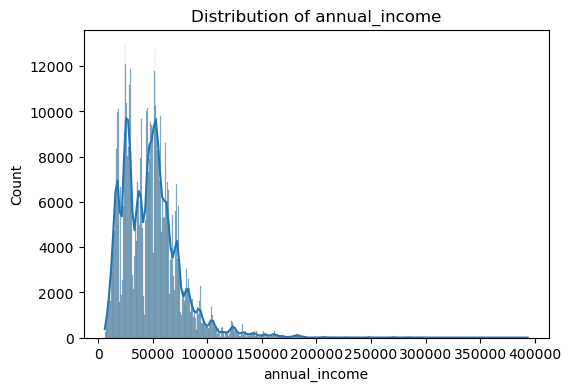

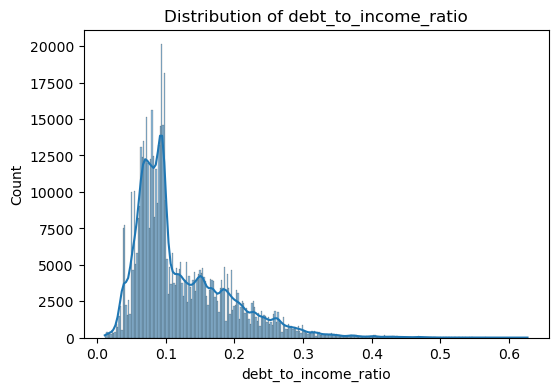

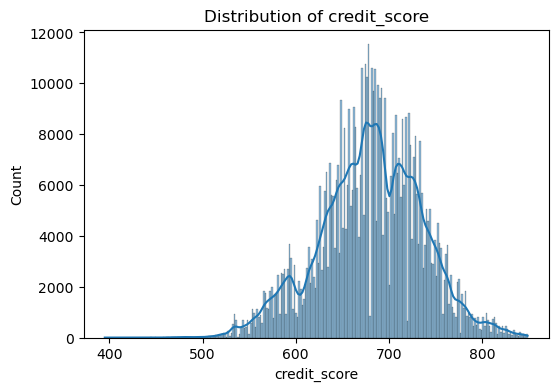

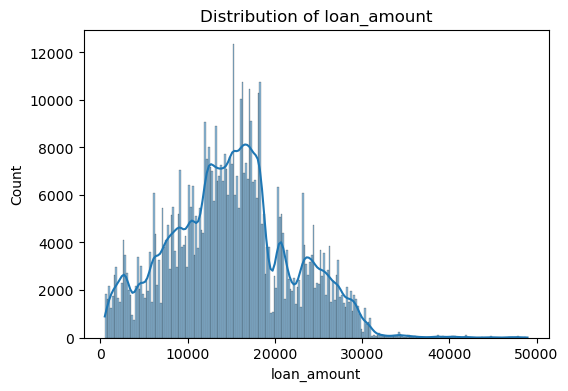

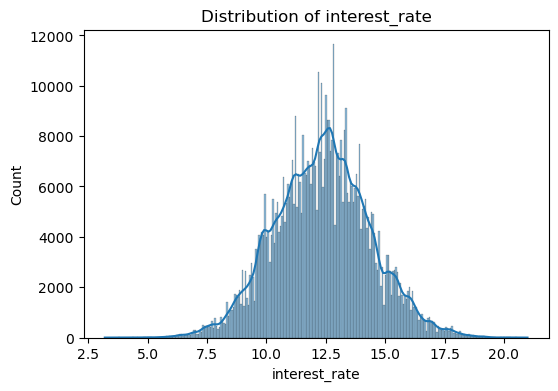

In [19]:
# make a hist plot for the distribution of numerical columns
numerical_cols = df.select_dtypes("number").drop(columns="loan_paid_back").columns

for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


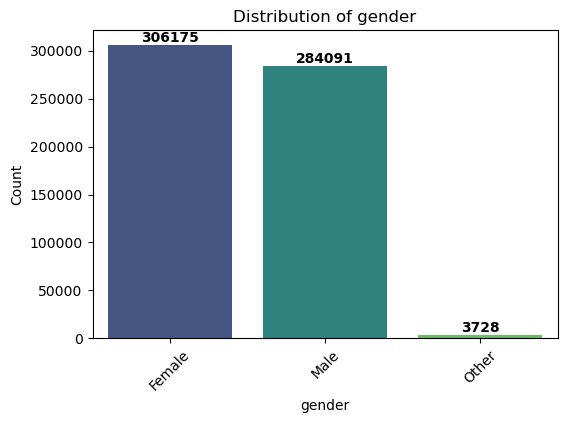

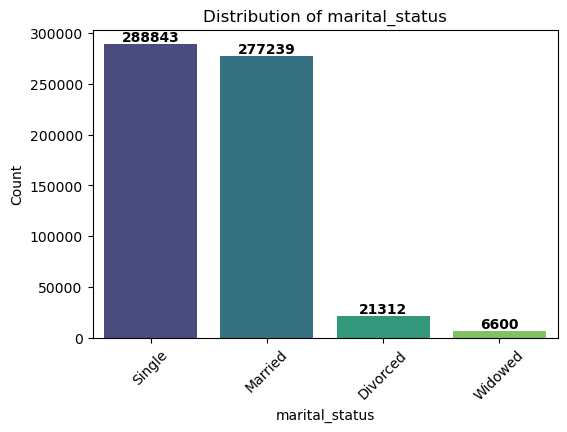

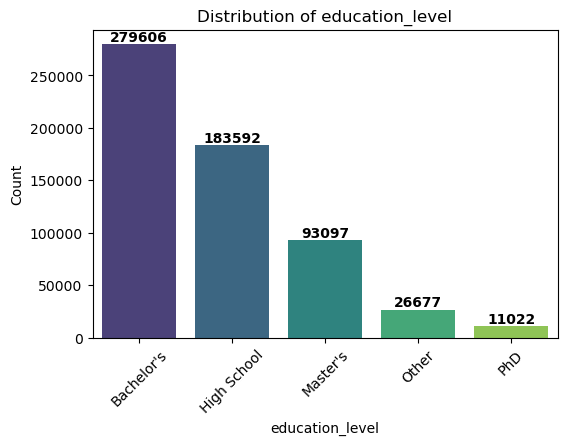

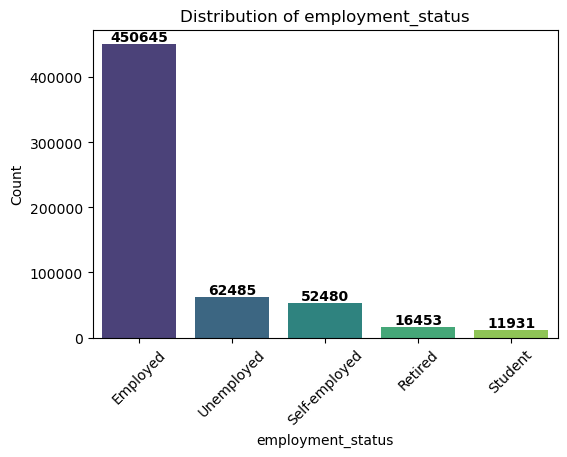

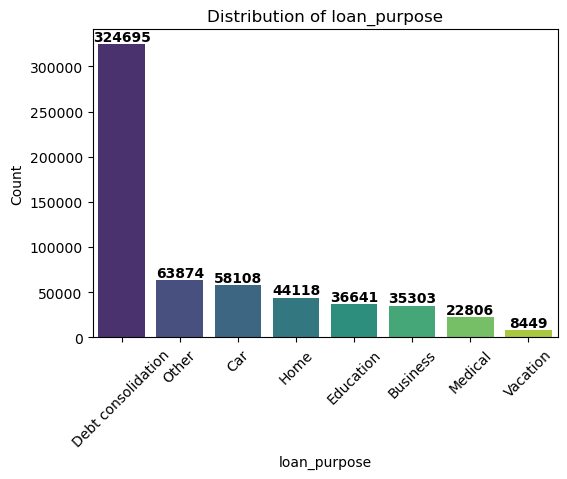

In [20]:
# make a bar plot for the distribution of categorical columns
categorical_cols = df.select_dtypes("object").drop(columns="grade_subgrade").columns

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    
    # Count values for the column
    value_counts = df[col].value_counts()
    
    # Create a vertical bar plot with multiple colors
    ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")
    
    # Add count labels on top of each bar
    for i, v in enumerate(value_counts.values):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')
    
    plt.title(f'Distribution of {col}')
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.xticks(rotation=45)  
    plt.show()

### Outliers <a class="anchor" id="Outliers"></a>
Using Boxplots, I checked for Outliers on the Loan Amount and Annuall Income and discovered that they both have  Outliers which is shown below as there are people who earn significantly more than others 

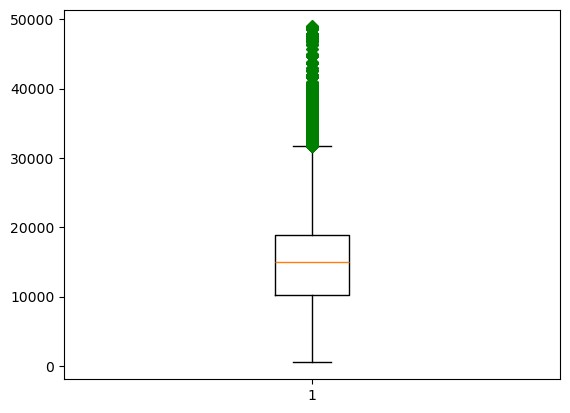

In [22]:
A = df['loan_amount']
plt.boxplot(A,0,'gD')
plt.show()

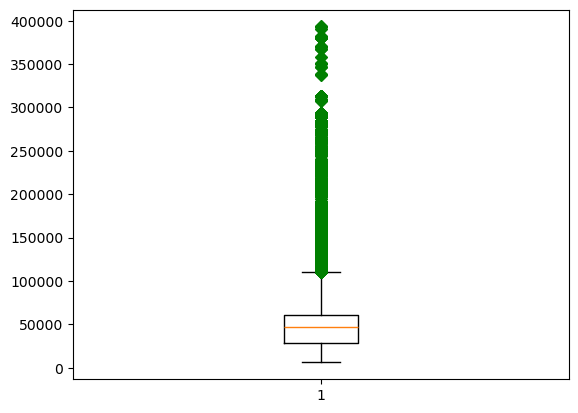

In [23]:
A = df['annual_income']
plt.boxplot(A,0,'gD')
plt.show()

### Bivariant Analysis <a class="anchor" id="bivariant"></a>

Looking at the various relationships that exist between variables.
We observed that:

* __the North Region did not carry out any online Purchase__
* __the South Region only Purchased online__
* __the West Region has equal amount of in-store and online Purchase__
* __the East Region has a higher in-store Purchase than the online Purchase__ 

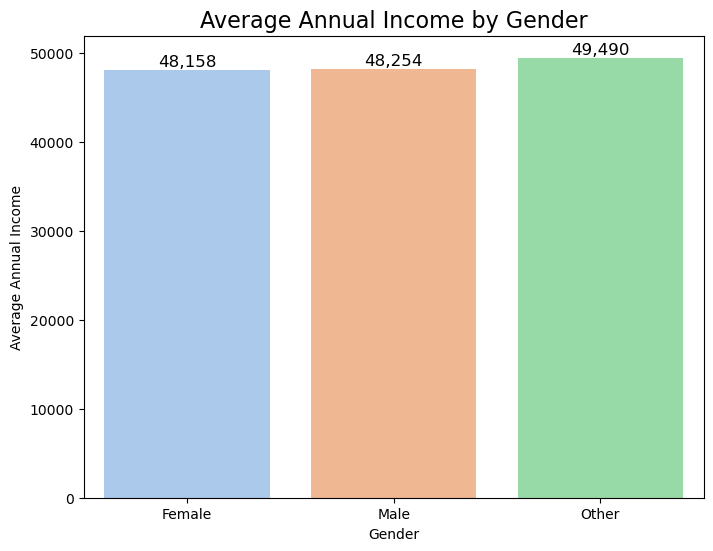

In [36]:
#Average annual imcome per gender
# Create bar plot
plt.figure(figsize=(8,6))
ax = sns.barplot(
    data=df,
    x='gender',
    y='annual_income',
    palette='pastel',
    ci=None
)

# Add value labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:,.0f}', 
        (p.get_x() + p.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.title("Average Annual Income by Gender", fontsize=16)
plt.xlabel("Gender")
plt.ylabel("Average Annual Income")
plt.show()


<Figure size 800x600 with 0 Axes>

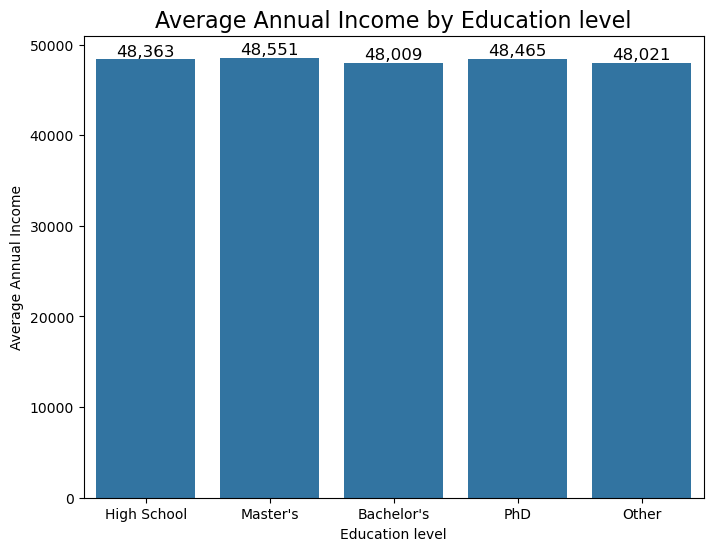

In [42]:
#Average annual imcome per Education Level
# Create bar plot
plt.figure(figsize=(8,6))
ax = sns.barplot(
    data=df,
    x='education_level',
    y='annual_income',
    ci=None
)

# Add value labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:,.0f}', 
        (p.get_x() + p.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.title("Average Annual Income by Education level", fontsize=16)
plt.xlabel("Education level")
plt.ylabel("Average Annual Income")
plt.show()


<Figure size 800x600 with 0 Axes>

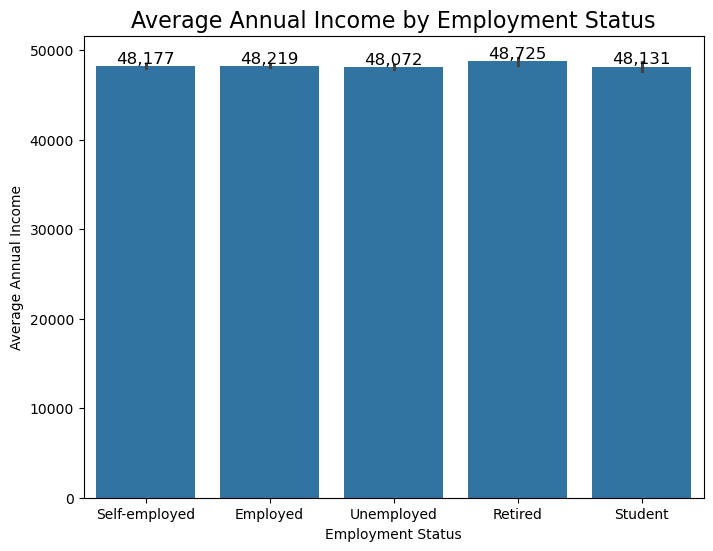

In [46]:
#Average annual imcome by Employment Status
# Create bar plot
plt.figure(figsize=(8,6))
ax = sns.barplot(
    data=df,
    x='employment_status',
    y='annual_income',
)

# Add value labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:,.0f}', 
        (p.get_x() + p.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.title("Average Annual Income by Employment Status", fontsize=16)
plt.xlabel("Employment Status")
plt.ylabel("Average Annual Income")
plt.show()


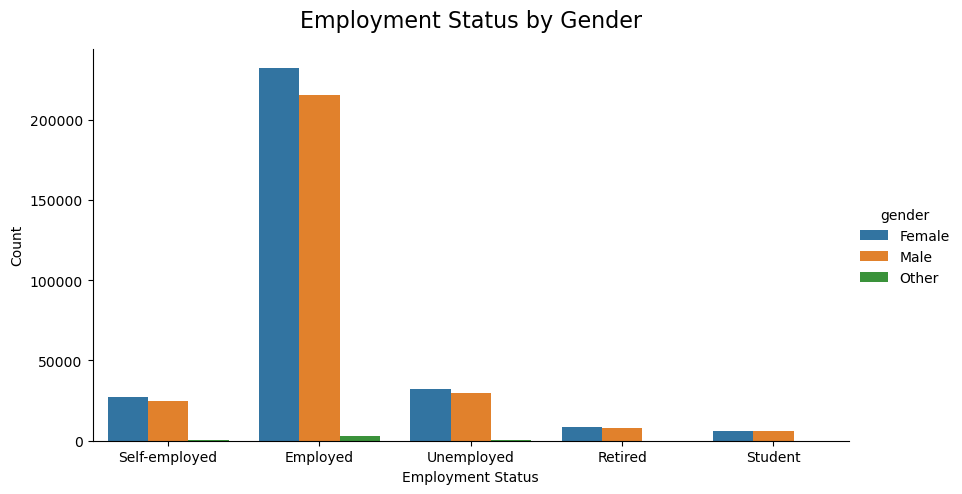

In [34]:
# Create the count plot
g = sns.catplot(
    data=df,
    x='employment_status', 
    hue='gender', 
    kind='count', 
    aspect=1.75
)

# Set title and x-axis label
g.fig.suptitle("Employment Status by Gender", fontsize=16)  
g.set_xlabels("Employment Status")
g.set_ylabels("Count") 

# Adjust layout so title doesn't overlap
g.fig.subplots_adjust(top=0.9)

plt.show()

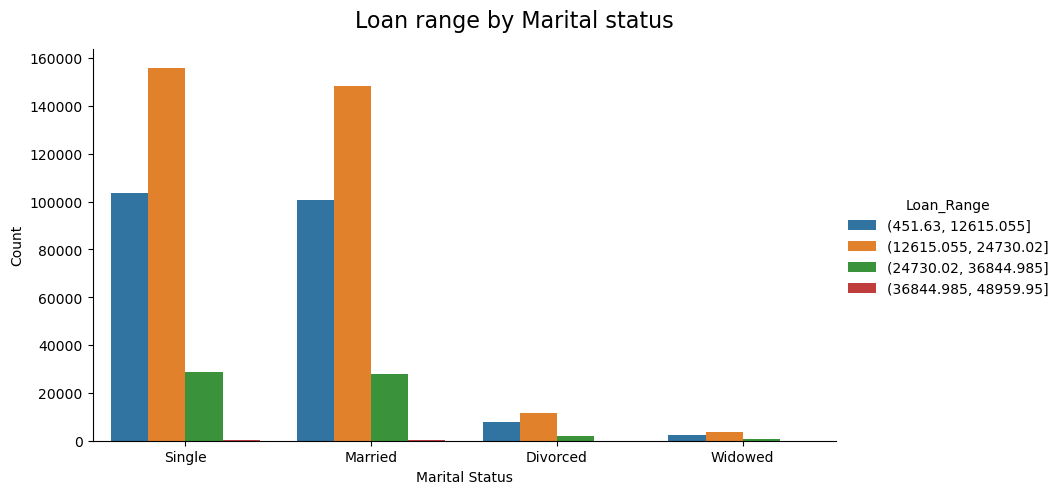

In [64]:
g = sns.catplot(
    data=df,
    x='marital_status', 
    hue='Loan_Range', 
    kind='count', 
    aspect=1.75
)

# Set title and x-axis label
g.fig.suptitle("Loan range by Marital status", fontsize=16)  
g.set_xlabels("Marital Status")
g.set_ylabels("Count") 

# Adjust layout so title doesn't overlap
g.fig.subplots_adjust(top=0.9)

plt.show()

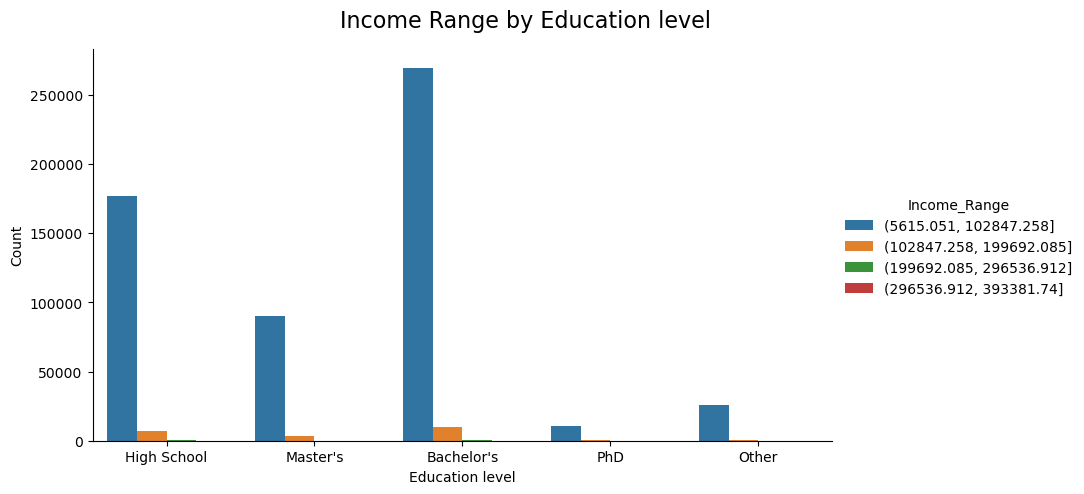

In [66]:
g = sns.catplot(
    data=df,
    x='education_level', 
    hue='Income_Range', 
    kind='count', 
    aspect=1.75
)

# Set title and x-axis label
g.fig.suptitle("Income Range by Education level", fontsize=16)  
g.set_xlabels("Education level")
g.set_ylabels("Count") 

# Adjust layout so title doesn't overlap
g.fig.subplots_adjust(top=0.9)


plt.show()

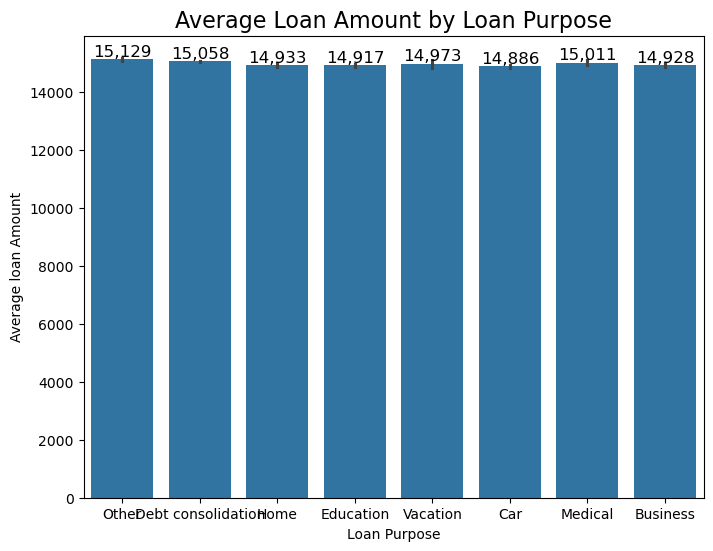

In [52]:
#Average Loan Amount by Loan Purpose
# Create bar plot
plt.figure(figsize=(8,6))
ax = sns.barplot(
    data=df,
    x='loan_purpose',
    y='loan_amount',
)

# Add value labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:,.0f}', 
        (p.get_x() + p.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.title("Average Loan Amount by Loan Purpose", fontsize=16)
plt.xlabel("Loan Purpose")
plt.ylabel("Average loan Amount")
plt.show()


#### Trends <a class="anchor" id="trends"></a>


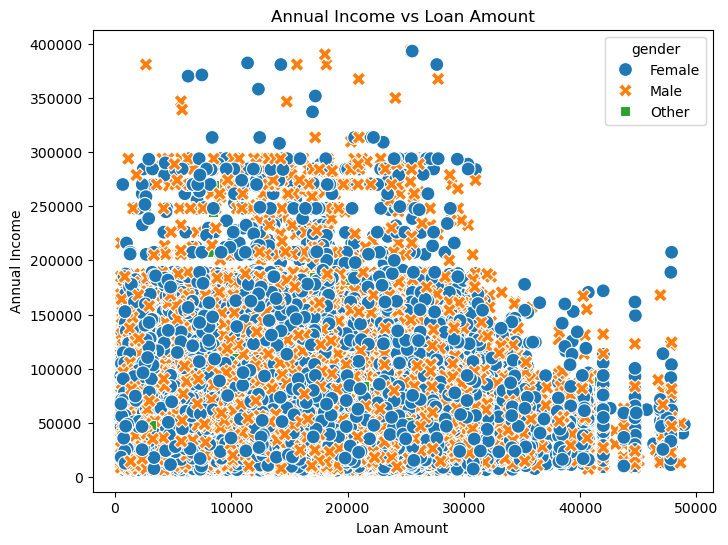

In [50]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='loan_amount',  # categorical
    y='annual_income',      # numerical
    hue='gender',           # optional: color by another category
    style='gender',         # optional: different markers
    s=100                   # marker size
)

plt.title("Annual Income vs Loan Amount")
plt.xlabel("Loan Amount")
plt.ylabel("Annual Income")
plt.show()


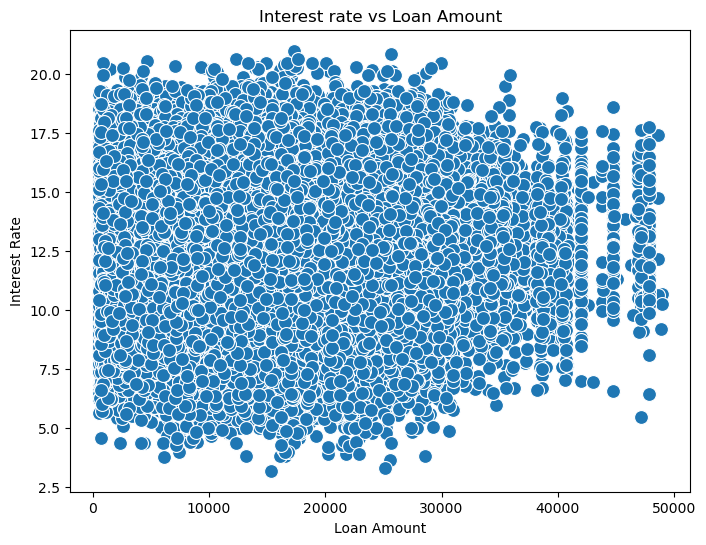

In [56]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='loan_amount',  # categorical
    y='interest_rate',      # numerical
    s=100                   # marker size
)

plt.title("Interest rate vs Loan Amount")
plt.xlabel("Loan Amount")
plt.ylabel("Interest Rate")
plt.show()


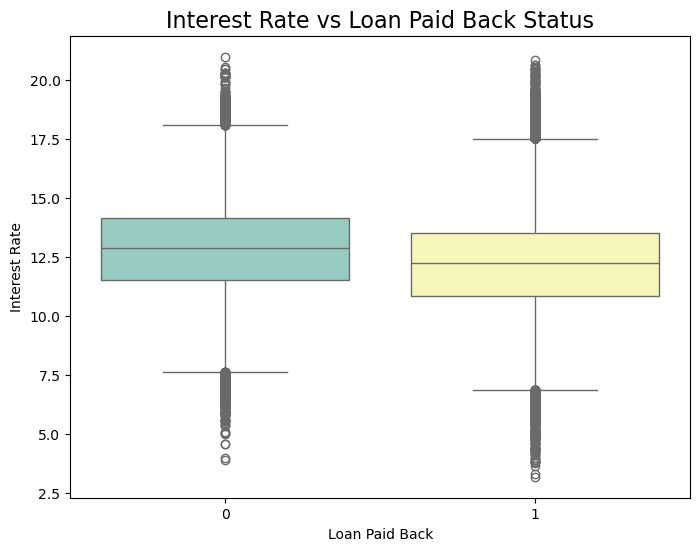

In [68]:
plt.figure(figsize=(8,6))
sns.boxplot(
    data=df,
    x='loan_paid_back',   
    y='interest_rate',    
    palette='Set3'
)

plt.title("Interest Rate vs Loan Paid Back Status", fontsize=16)
plt.xlabel("Loan Paid Back")
plt.ylabel("Interest Rate")
plt.show()


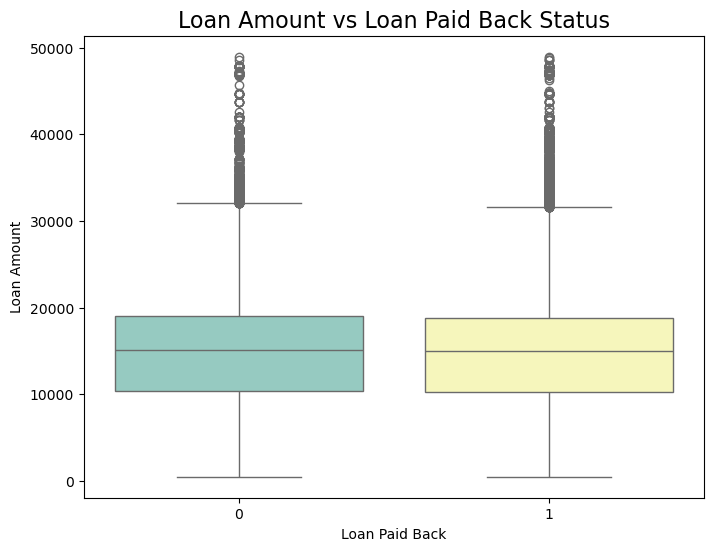

In [70]:
plt.figure(figsize=(8,6))
sns.boxplot(
    data=df,
    x='loan_paid_back',   # categorical
    y='loan_amount',    # numeric
    palette='Set3'
)

plt.title("Loan Amount vs Loan Paid Back Status", fontsize=16)
plt.xlabel("Loan Paid Back")
plt.ylabel("Loan Amount")
plt.show()


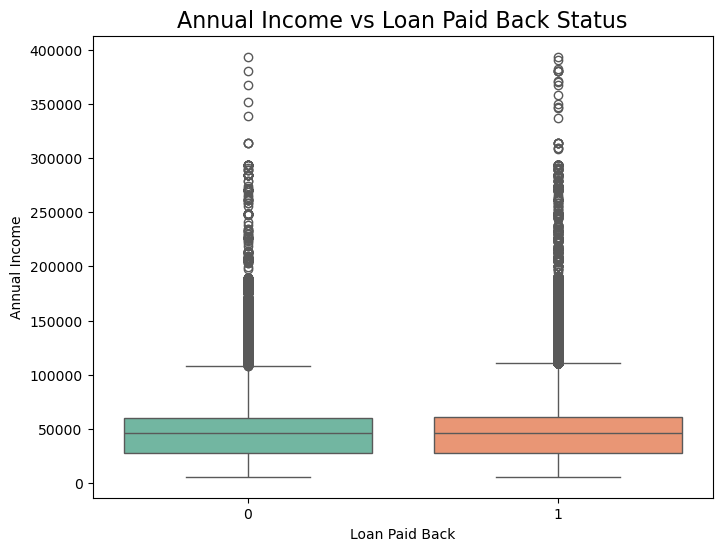

In [72]:
plt.figure(figsize=(8,6))
sns.boxplot(
    data=df,
    x='loan_paid_back',
    y='annual_income',
    palette='Set2'
)

plt.title("Annual Income vs Loan Paid Back Status", fontsize=16)
plt.xlabel("Loan Paid Back")
plt.ylabel("Annual Income")
plt.show()

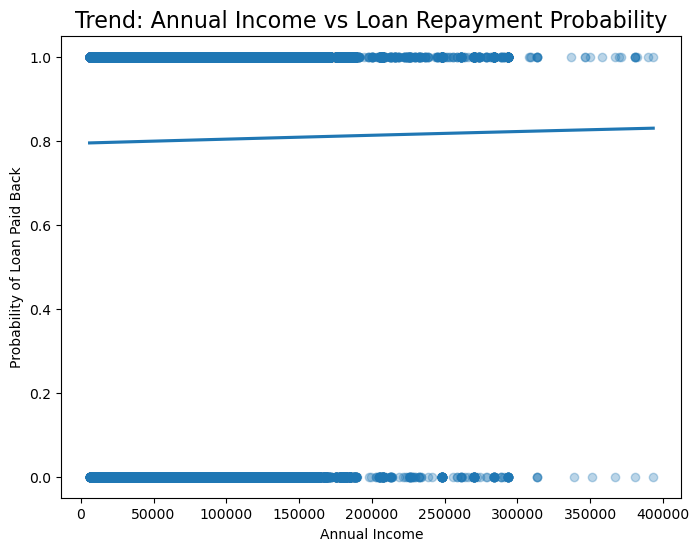

In [74]:
plt.figure(figsize=(8,6))
sns.regplot(
    data=df,
    x='annual_income',
    y='loan_paid_back',
    logistic=True,  # logistic regression curve
    ci=None,
    scatter_kws={'alpha':0.3}
)

plt.title("Trend: Annual Income vs Loan Repayment Probability", fontsize=16)
plt.xlabel("Annual Income")
plt.ylabel("Probability of Loan Paid Back")
plt.show()

# Model Building <a class="anchor" id="model"></a>


## Data Transformation <a class="anchor" id="data transformation"></a>


In [89]:
# Define numerical and categorical columns
numerical_cols = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', "interest_rate"]
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()


In [100]:
# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)


In [103]:
# Split data into features (X) and target (y)
target="loan_paid_back"
features = ["annual_income", 
            "debt_to_income_ratio",
            "credit_score",
            "loan_amount",
            "interest_rate",
            "gender",
            "marital_status",
            "education_level",
            "employment_status",
            "loan_purpose"]
X_train= df[features]
y_train = df[target]
print(X_train.shape)
print(y_train.shape)

(593994, 10)
(593994,)


## Logistic Regression Model <a class="anchor" id="lr-model"></a>


In [ ]:
lr_model = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=1000)
)



In [ ]:
 #Create k-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Conduct k-fold cross-validation
cv_lr = cross_val_score(lr_model, # Model
                        X_train, # Feature matrix
                        y_train, # Target vector
                        cv=kf, # Performance metric
                        scoring="accuracy" # Loss function
                        ) 

print("Logistic Regression CV Accuracy on training set:", np.mean(cv_scores), "±", np.std(cv_scores))


## CatBoost Model  <a class="anchor" id="catboost"></a>


In [ ]:
# Preprocessor: only scale numerical features
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols)
    ],
    remainder='passthrough'  # leave categorical columns as-is
)


In [ ]:
# Define a pipeline with preprocessor and CatBoost
catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor_2),
    ('catboost', CatBoostClassifier(verbose=0, random_state=42))
])


In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_idx, val_idx in kf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Create Pool objects to tell CatBoost which columns are categorical
    train_pool = Pool(X_tr, y_tr, cat_features=categorical_cols)
    val_pool = Pool(X_val, y_val, cat_features=categorical_cols)
    
    # Fit model
    catboost_pipeline.named_steps['catboost'].fit(train_pool)
    
    # Evaluate
    scores.append(catboost_pipeline.named_steps['catboost'].score(val_pool))

print("CatBoost CV Accuracy:", np.mean(scores), "±", np.std(scores))

## LightGB Model <a class="anchor" id="lightgb-model"></a>


In [ ]:
# Create pipeline with LightGBM
lgb_pipeline = Pipeline([
    ('preprocessor', preprocessor_2),
    ('lgb', LGBMClassifier(random_state=42))
])


In [ ]:
# ----- K-Fold Cross-Validation -----
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_idx, val_idx in kf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # LightGBM can take categorical features via 'categorical_feature' param
    lgb_pipeline.named_steps['lgb'].fit(
        X_tr, y_tr,
        categorical_feature=categorical_cols,
        eval_set=[(X_val, y_val)],
        verbose=0
    )
    
    # Evaluate
    scores.append(lgb_pipeline.named_steps['lgb'].score(X_val, y_val))

print("LightGBM CV Accuracy:", np.mean(scores), "±", np.std(scores))
